In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [ ]:
#hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.13.0
Using accelerate v0.5.1


# Multilingual Named Entity Recognition

## The Dataset

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [2]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [3]:
xtreme_subsets[:5]

['XNLI', 'tydiqa', 'SQuAD', 'PAN-X.af', 'PAN-X.ar']

In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [5]:
# hide_output
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

Found cached dataset xtreme (C:/Users/qilin/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [6]:
# hide_output
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)
panx_ch

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

Found cached dataset xtreme (C:/Users/qilin/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-e5ddf09f1ae095ec.arrow
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-25e7e2dd003d0fa6.arrow
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-73a95bc0accfea8b.arrow
Found cached dataset xtreme (C:/Users/qilin/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-6ff29513007ec78b.arrow
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-c5c9a4fc19dfd7d6.arrow
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-9711ab25936b81b7.arrow
Found cached dataset xtreme (C:/Users/qilin/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-daa9a1770078307c.arrow
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-5e244c05031bab3c.arrow
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-497ee15c12bff58d.arrow
Found cached dataset xtreme (C:/Users/qilin/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-757845faa9fa6949.arrow
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-305cefc7ffa49fd9.arrow
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-e5ec5e6ba7c1237d.arrow


In [7]:
panx_ch['en']['train']

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 1180
})

In [10]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [11]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [8]:
for key, value in panx_ch["de"]["train"].features.items():  # : panx_ch["de"]["train"].features is a dict
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [9]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)
print(tags.int2str(4))

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
I-ORG


In [10]:
# hide_output
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)  # : so this mapping creates additional features named 'ner_tags_str'
print(panx_de)

Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-f3309bc5e9d28268.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-36ed4bdaca6e2a48.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-a08bda4878cb6bac.arrow


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})


In [16]:
# hide_output
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [18]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## Multilingual Transformers

## A Closer Look at Tokenization

In [11]:
# hide_output
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [12]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [21]:
#hide_input
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### The Tokenizer Pipeline

<img alt="Tokenizer pipeline" caption="The steps in the tokenization pipeline" src="images/chapter04_tokenizer-pipeline.png" id="toknizer-pipeline"/>

### The SentencePiece Tokenizer

In [22]:
print("".join(xlmr_tokens))
print("".join(xlmr_tokens).replace(u"\u2581", " "))

<s>▁Jack▁Sparrow▁loves▁New▁York!</s>
<s> Jack Sparrow loves New York!</s>


## Transformers for Named Entity Recognition

<img alt="Architecture of a transformer encoder for classification." caption="Fine-tuning an encoder-based transformer for sequence classification" src="images/chapter04_clf-architecture.png" id="clf-arch"/>

<img alt="Architecture of a transformer encoder for named entity recognition. The wide linear layer shows that the same linear layer is applied to all hidden states." caption="Fine-tuning an encoder-based transformer for named entity recognition" src="images/chapter04_ner-architecture.png" id="ner-arch"/>

## The Anatomy of the Transformers Model Class

### Bodies and Heads

<img alt="bert-body-head" caption="The `BertModel` class only contains the body of the model, while the `BertFor&lt;Task&gt;` classes combine the body with a dedicated head for a given task" src="images/chapter04_bert-body-head.png" id="bert-body-head"/>

### Creating a Custom Model for Token Classification

In [13]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)  # : return all, not just CLS
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))  # : loss(input, label)
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,  # : TokenClassifierOutput class
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

### Loading a Custom Model

In [14]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [15]:
# hide_output
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [16]:
# hide_output
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classif

In [17]:
# hide_output
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [28]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [29]:
# : note
xlmr_model(input_ids.to(device))

TokenClassifierOutput(loss=None, logits=tensor([[[ 2.9491e-01, -1.4722e-01,  2.3203e-01, -5.8347e-01, -3.7713e-02,
          -5.8250e-02, -9.1335e-01],
         [ 9.9618e-02, -3.9073e-01,  2.5161e-01, -2.1589e-04, -1.6590e-02,
           1.3126e-01, -7.0890e-01],
         [ 7.8177e-02, -3.9373e-01,  3.0029e-01, -8.0473e-02,  5.6447e-02,
           1.2184e-01, -6.4477e-01],
         [ 1.8236e-01, -4.4992e-01,  2.5176e-01,  2.4101e-02, -1.8578e-02,
           5.3543e-02, -7.4407e-01],
         [ 1.8414e-01, -3.6823e-01,  2.4701e-01, -1.9518e-02,  6.5516e-03,
           3.6565e-02, -7.3769e-01],
         [ 2.5685e-01, -3.3242e-01,  2.0399e-01, -2.0063e-02, -4.3463e-02,
          -1.5657e-02, -7.3047e-01],
         [ 1.5265e-01, -4.2270e-01,  1.8858e-01,  5.8963e-02,  4.8361e-02,
           1.5310e-01, -7.0945e-01],
         [ 1.2026e-01, -4.1626e-01,  2.4344e-01,  1.5473e-02,  1.6552e-02,
           1.4508e-01, -7.0965e-01],
         [ 1.9520e-01, -3.4426e-01,  2.1003e-01,  1.9844e-02, -2

In [30]:
tags.names  # :

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [31]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])  # : very poor

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,O,I-PER,I-PER,I-PER,I-PER,O,I-PER,I-PER,I-PER,I-PER


In [18]:
# : wrap everything into a helper function
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    

## Tokenizing Texts for NER

In [33]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [34]:
words, labels  # :

(['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0])

In [35]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [36]:
#hide_output
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [37]:
# hide_output
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [38]:
#hide_output
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])  # : labels was int index
    previous_word_idx = word_idx
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [19]:
# ! to the whole dataset
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [20]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [21]:
# hide_output
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-d76c2dcc0ec782ff.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-09bf7bdc09191ef8.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-4902ff88ff9769c6.arrow


In [42]:
panx_de_encoded['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

## Performance Measures

In [43]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [22]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## Fine-Tuning XLM-RoBERTa

In [46]:
# hide_output
from transformers import TrainingArguments

num_epochs = 3
batch_size = 7
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True,
    report_to="none")  # : extra for disabling neptune)

In [19]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (manager-core).
Your token has been saved to C:\Users\qilin\.cache\huggingface\token
Login successful


In [24]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [25]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [26]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [72]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [27]:
# hide_output
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,  # no longer model, but model_init
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

D:\Users\qilin\CloudStation\_MILA\6289\nlp-with-transformers\xlm-roberta-base-finetuned-panx-de is already a clone of https://huggingface.co/qilin1/xlm-roberta-base-finetuned-panx-de. Make sure you pull the latest changes with `repo.git_pull()`.


In [50]:
#hide_input
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

C:\Users\qilin\.conda\envs\qw\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 32.0k/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 32.0k/16.3M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.42k/3.42k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   1%|          | 32.0k/4.83M [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/qilin1/xlm-roberta-base-finetuned-panx-de
   a14f875..67645fc  main -> main

To https://huggingface.co/qilin1/xlm-roberta-base-finetuned-panx-de
   67645fc..904a827  main -> main



'https://huggingface.co/qilin1/xlm-roberta-base-finetuned-panx-de/commit/67645fc1333ad17acad3576da66c501f31c86e23'

In [ ]:
# hide_input
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

Epoch,Training Loss,Validation Loss,F1
1,0.2652,0.160244,0.822974
2,0.1314,0.137195,0.852747
3,0.0806,0.138774,0.864591


In [51]:
# hide_output
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


## Error Analysis

In [63]:
# gpt example
# Dictionary of lists
dict_of_lists = {'fruit': ['apple', 'banana', 'orange'], 'color': ['red', 'yellow', 'orange']}
print(dict_of_lists)
print(dict_of_lists.values())
print(*dict_of_lists.values())
print(f'-----')
# Convert dictionary of lists to list of dictionaries
print([t for t in zip(*dict_of_lists.values())])
print([list(zip(dict_of_lists, t)) for t in zip(*dict_of_lists.values())])

list_of_dicts = [dict(zip(dict_of_lists, t)) for t in zip(*dict_of_lists.values())]
print(f'-----')
# Output the result
print(list_of_dicts)

{'fruit': ['apple', 'banana', 'orange'], 'color': ['red', 'yellow', 'orange']}
dict_values([['apple', 'banana', 'orange'], ['red', 'yellow', 'orange']])
['apple', 'banana', 'orange'] ['red', 'yellow', 'orange']
-----
[('apple', 'red'), ('banana', 'yellow'), ('orange', 'orange')]
[[('fruit', 'apple'), ('color', 'red')], [('fruit', 'banana'), ('color', 'yellow')], [('fruit', 'orange'), ('color', 'orange')]]
-----
[{'fruit': 'apple', 'color': 'red'}, {'fruit': 'banana', 'color': 'yellow'}, {'fruit': 'orange', 'color': 'orange'}]


In [28]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")  # : two ways of using cross_entropy: with classes or with probabilities
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [65]:
# hide_output
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)


Parameter 'function'=<function forward_pass_with_label at 0x0000022328F9C3A0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [88]:
# hide_output
df = valid_set.to_pandas()
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0017051456, 0.0, 0.0036322589, 0.00301...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [72]:
# hide_output
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.00,B-ORG,▁Ham
0,15,1,I-ORG,0.00,I-ORG,▁(
0,16104,1,I-ORG,0.00,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.00,I-ORG,▁)
1,56530,1,O,0.01,O,▁WE
1,83982,1,B-ORG,0.15,B-ORG,▁Luz
1,10,1,I-ORG,0.23,I-ORG,▁a


In [73]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁(,▁),▁und,▁'',▁A,▁/
count,6066,1388,989,808,246,246,1171,2898,125,163
mean,0.04,0.15,0.15,0.18,0.54,0.51,0.1,0.03,0.68,0.5
sum,259.43,211.95,150.38,147.33,133.34,124.58,122.23,85.11,84.53,80.82


In [74]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.92,0.74,0.61,0.47,0.33,0.25,0.04
sum,1338.38,1996.54,2322.56,1499.1,961.58,1037.35,1659.93


In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

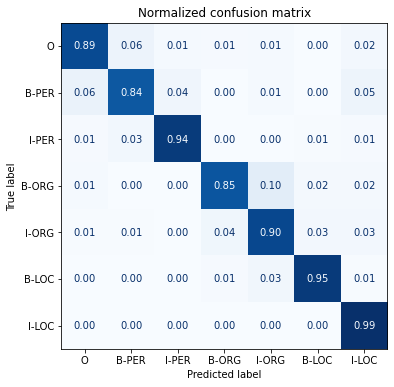

In [78]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [84]:
# gpt
import pandas as pd
# df.iterrows()
# It returns an iterator that yields both the index and row data as a tuple.

# Create a sample DataFrame
df1 = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie'], 'age': [25, 30, 35]})
print(df1)
print("\n")
# Iterate over the rows of the DataFrame
for index, row in df1.iterrows():
    print(f"Index: {index}")
    print(f"Name: {row['name']}")
    print(f"Age: {row['age']}")


      name  age
0    Alice   25
1      Bob   30
2  Charlie   35


Index: 0
Name: Alice
Age: 25
Index: 1
Name: Bob
Age: 30
Index: 2
Name: Charlie
Age: 35


In [86]:
# gpt
# In Python, yield is used in a function to define a generator. A generator is a special type of iterator that can be paused and resumed at any time, allowing the function to return a series of values one at a time instead of all at once.

def my_generator():
    print("Generator started!")
    yield 1
    print("Value 1 yielded!")
    yield 2
    print("Value 2 yielded!")
    yield 3
    print("Value 3 yielded!")
    print("Generator finished!")

gen = my_generator() # create a generator object

for value in gen:
    print("Received value:", value)

# When you start iterating over the generator object gen, the function is executed up to the first yield statement.
# The value of 1 is returned from the generator, and the function is paused at the yield statement.
# When you iterate over the generator object again, the function resumes execution immediately after the last yield statement.
# the second yield statement is encountered, and the value of 2 is returned from the generator. The function is paused again.
# The process repeats for the third yield statement, returning 3.
# Since there are no more yield statements in the function, the generator function is complete and the generator object is exhausted.

Generator started!
Received value: 1
Value 1 yielded!
Received value: 2
Value 2 yielded!
Received value: 3
Value 3 yielded!
Generator finished!


In [89]:
# hide_output
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,2.18,0.00,0.00,0.00,11.98,11.49,8.48,9.73,8.86,0.00,10.39,9.41,0.00,10.17,9.26,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,10.61,0.00,0.00,8.04,10.80,10.57,9.06,0.00,8.48,8.98,8.59,8.02,8.66,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,8.44,7.41,7.60,0.00,7.41,0.00,7.38,0.00,7.12,6.88,7.21,7.58,7.34,7.08,0.00


In [90]:
# hide_output
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Cross-Lingual Transfer

In [29]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [30]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

KeyboardInterrupt: 

In [93]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,B-LOC,I-LOC,O


In [32]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [95]:
# hide_output
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.707


In [97]:
# hide_input
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.707


In [98]:
# hide_output
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.667


In [99]:
# hide_input
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.667


In [31]:
#hide_output
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

NameError: name 'evaluate_lang_performance' is not defined

In [101]:
#hide_input
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.576


### When Does Zero-Shot Transfer Make Sense?

In [33]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [34]:
# hide_output
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-e1919ac3c2a04d9a.arrow


Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-b04adacda5246119.arrow


In [ ]:
torch.cuda.empty_cache()

In [35]:
# hide_output
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

C:\Users\qilin\.conda\envs\qw\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


,num_samples,f1_score
0,250,0.71222


In [36]:
# hide_output
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-ebb3d0cada8e5d39.arrow
C:\Users\qilin\.conda\envs\qw\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


C:\Users\qilin\AppData\Local\Temp\ipykernel_40356\474267531.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-ebb3d0cada8e5d39.arrow


Epoch,Training Loss,Validation Loss


Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-ebb3d0cada8e5d39.arrow


Epoch,Training Loss,Validation Loss


Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-ebb3d0cada8e5d39.arrow


Epoch,Training Loss,Validation Loss


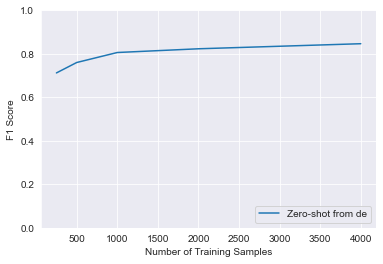

In [40]:

fig, ax = plt.subplots()
# ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### Fine-Tuning on Multiple Languages at Once

In [41]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [42]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [43]:
# hide_output
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Cloning https://huggingface.co/qilin1/xlm-roberta-base-finetuned-panx-de-fr into local empty directory.
C:\Users\qilin\.conda\envs\qw\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 32.0k/1.03G [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   1%|          | 32.0k/4.83M [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 32.0k/16.3M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.48k/3.48k [00:00<?, ?B/s]

KeyboardInterrupt: 

In [44]:
#hide_output
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-0ce791e258df6488.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-88460cc0709a509a.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-b04adacda5246119.arrow


F1-score of [de-fr] model on [de] dataset: 0.861


Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-f3fee4c36f9ac67b.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-0c5a559295aaefee.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-b90402de861e6a85.arrow


F1-score of [de-fr] model on [fr] dataset: 0.858


Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-a6964af9da4e0308.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-aaa790ce8d0eb1cd.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-63d4abbcd16b6023.arrow


F1-score of [de-fr] model on [it] dataset: 0.758


F1-score of [de-fr] model on [en] dataset: 0.673


In [45]:
#hide_input
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-a5e8d4341bff0264.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-71422318581e93e5.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.de\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-b0635f1fad4df39e.arrow


Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-0ce791e258df6488.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-88460cc0709a509a.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-b04adacda5246119.arrow


F1-score of [de-fr] model on [de] dataset: 0.861


Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-f3fee4c36f9ac67b.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-0c5a559295aaefee.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.it\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-b90402de861e6a85.arrow


F1-score of [de-fr] model on [fr] dataset: 0.858


Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-a6964af9da4e0308.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-aaa790ce8d0eb1cd.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.en\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-63d4abbcd16b6023.arrow


F1-score of [de-fr] model on [it] dataset: 0.758


F1-score of [de-fr] model on [en] dataset: 0.673


In [ ]:
# hide_output
corpora = [panx_de_encoded]
corpora, langs

In [ ]:

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

In [ ]:
corpora_encoded = concatenate_splits(corpora)

In [ ]:
# hide_output
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
# hide_output
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [ ]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

## Interacting with Model Widgets

<img alt="A Hub widget" caption="Example of a widget on the Hugging Face Hub" src="images/chapter04_ner-widget.png" id="ner-widget"/>

## Conclusion

In [109]:
# hide_output
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Loading cached shuffled indices for dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-b282eaeed5f7962e.arrow


RuntimeError: CUDA out of memory. Tried to allocate 734.00 MiB (GPU 0; 12.00 GiB total capacity; 10.35 GiB already allocated; 0 bytes free; 10.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#hide_input
# Hack needed to exclude the progress bars in the above cell
metrics_df

In [ ]:
# hide_output
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

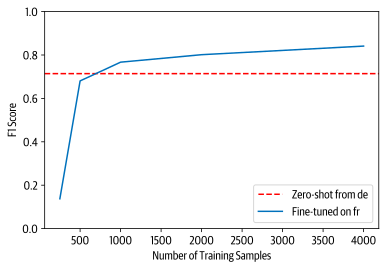

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### Fine-Tuning on Multiple Languages at Once

In [ ]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [ ]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [ ]:
# hide_output
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
#hide_output
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.866
F1-score of [de-fr] model on [fr] dataset: 0.868
F1-score of [de-fr] model on [it] dataset: 0.815
F1-score of [de-fr] model on [en] dataset: 0.677


In [ ]:
#hide_input
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.866
F1-score of [de-fr] model on [fr] dataset: 0.868
F1-score of [de-fr] model on [it] dataset: 0.815
F1-score of [de-fr] model on [en] dataset: 0.677


In [104]:
# hide_output
corpora = [panx_de_encoded]
corpora, langs

([DatasetDict({
      train: Dataset({
          features: ['input_ids', 'attention_mask', 'labels'],
          num_rows: 12580
      })
      validation: Dataset({
          features: ['input_ids', 'attention_mask', 'labels'],
          num_rows: 6290
      })
      test: Dataset({
          features: ['input_ids', 'attention_mask', 'labels'],
          num_rows: 6290
      })
  })],
 ['de', 'fr', 'it', 'en'])

In [105]:

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-88460cc0709a509a.arrow
Loading cached processed dataset at C:\Users\qilin\.cache\huggingface\datasets\xtreme\PAN-X.fr\1.0.0\29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4\cache-b04adacda5246119.arrow


NameError: name 'train_on_subset' is not defined

In [ ]:
corpora_encoded = concatenate_splits(corpora)

In [102]:
# hide_output
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

NameError: name 'corpora_encoded' is not defined

In [ ]:
# hide_output
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [ ]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8677,0.7141,0.6923,0.5890
each,0.8677,0.8505,0.8192,0.7068
all,0.8682,0.8647,0.8575,0.7870


## Interacting with Model Widgets

<img alt="A Hub widget" caption="Example of a widget on the Hugging Face Hub" src="images/chapter04_ner-widget.png" id="ner-widget"/>  

## Conclusion